# Setup

In [1]:
# Import necessary libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import imageio
import shutil

# --- Define Local File Paths ---

# Path to your WHO AQI CSV file
csv_file_path = 'who_aqi.csv'

# Path to your UNZIPPED Natural Earth .shp file
world_map_shp_path = './NE_countries/ne_110m_admin_0_countries.shp'

# Directory to save temporary image frames for the GIF
temp_frames_dir = './temp_global_aqi_frames/'

# Output path for the final GIF animation
output_gif_path = './global_pm10_aqi_animation.gif'

# --- Create necessary directories ---
# os.makedirs(temp_frames_dir, exist_ok=True)
# print(f"Temporary directory for frames created: {temp_frames_dir}")

In [2]:
df = pd.read_csv(csv_file_path)
print("CSV file loaded successfully as a pandas DataFrame!")

# --- Data Cleaning and Preparation for GeoDataFrame ---
pollutant_column = 'pm10_concentration'
legend_label = "PM10 Concentration (µg/m³)" # Corrected from PM1.0

if 'latitude' in df.columns and 'longitude' in df.columns and pollutant_column in df.columns:
    print(f"Preparing data for GeoDataFrame conversion using '{pollutant_column}'...")

    initial_rows = len(df)
    df_cleaned = df.dropna(subset=['latitude', 'longitude', pollutant_column]).copy()
    rows_after_drop = len(df_cleaned)
    print(f"Dropped {initial_rows - rows_after_drop} rows with missing essential data.")

    # Ensure latitude, longitude, and pollutant_column are numeric.
    df_cleaned['latitude'] = pd.to_numeric(df_cleaned['latitude'], errors='coerce')
    df_cleaned['longitude'] = pd.to_numeric(df_cleaned['longitude'], errors='coerce')
    df_cleaned[pollutant_column] = pd.to_numeric(df_cleaned[pollutant_column], errors='coerce')

    # Drop any rows that became NaN after coercion
    df_cleaned.dropna(subset=['latitude', 'longitude', pollutant_column], inplace=True)
    print(f"Remaining rows after ensuring numeric types: {len(df_cleaned)}")
    df_cleaned['year'] = df_cleaned['year'].astype(int)

    # Convert to GeoDataFrame
    print("Converting to GeoDataFrame...")
    gdf = gpd.GeoDataFrame(
        df_cleaned,
        geometry=gpd.points_from_xy(df_cleaned.longitude, df_cleaned.latitude),
        crs="EPSG:4326" # Standard for lat/lon coordinates
    )
    print("GeoDataFrame created successfully!")
    print(f"GeoDataFrame Head:\n{gdf.head()}")
    print(f"GeoDataFrame CRS: {gdf.crs}")

CSV file loaded successfully as a pandas DataFrame!
Preparing data for GeoDataFrame conversion using 'pm10_concentration'...
Dropped 11716 rows with missing essential data.
Remaining rows after ensuring numeric types: 28672
Converting to GeoDataFrame...
GeoDataFrame created successfully!
GeoDataFrame Head:
  who_region iso3 country_name          city  year  \
0      4_Eur  ESP        Spain  A Coruna/ESP  2013   
1      4_Eur  ESP        Spain  A Coruna/ESP  2014   
2      4_Eur  ESP        Spain  A Coruna/ESP  2015   
3      4_Eur  ESP        Spain  A Coruna/ESP  2016   
4      4_Eur  ESP        Spain  A Coruna/ESP  2017   

                                             version  pm10_concentration  \
0  V4.0 (2018), V4.0 (2018), V4.0 (2018), V4.0 (2...              23.238   
1           V6.0  (2023), V6.0  (2023), V6.0  (2023)              27.476   
2  V6.0  (2023), V6.0  (2023), V6.0  (2023), V6.0...              25.515   
3  V6.0  (2023), V6.0  (2023), V6.0  (2023), V6.0...           

In [3]:
world = gpd.read_file(world_map_shp_path)
print("World map data loaded successfully!")
print(f"World map CRS: {world.crs}")

World map data loaded successfully!
World map CRS: EPSG:4326


In [20]:
gdf['year']

0        2013
1        2014
2        2015
3        2016
4        2017
         ... 
40091    2015
40092    2016
40093    2017
40094    2018
40095    2019
Name: year, Length: 28672, dtype: int64

Years available in data: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


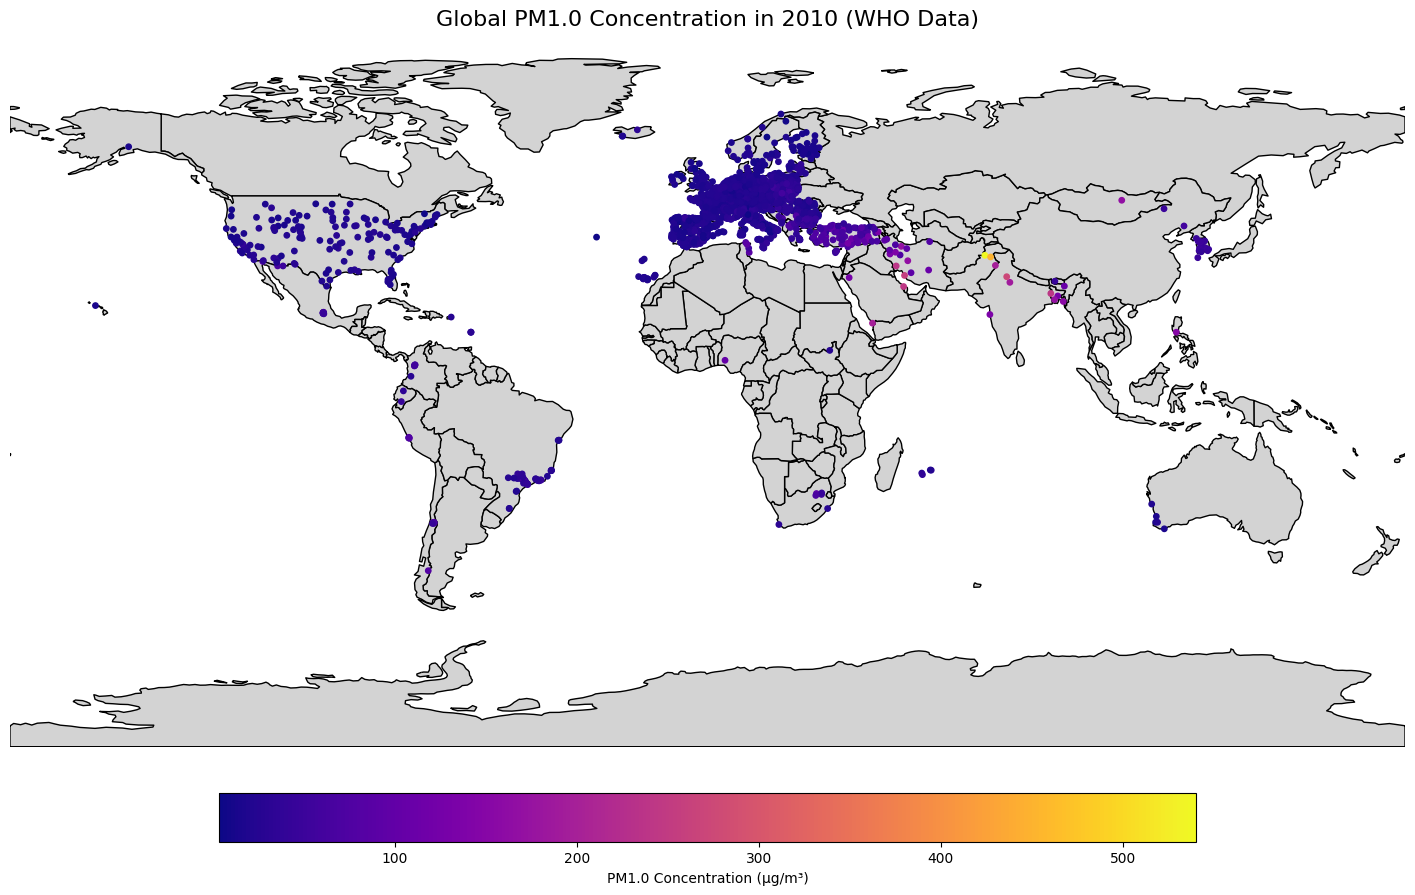

Saved frame for year 2010


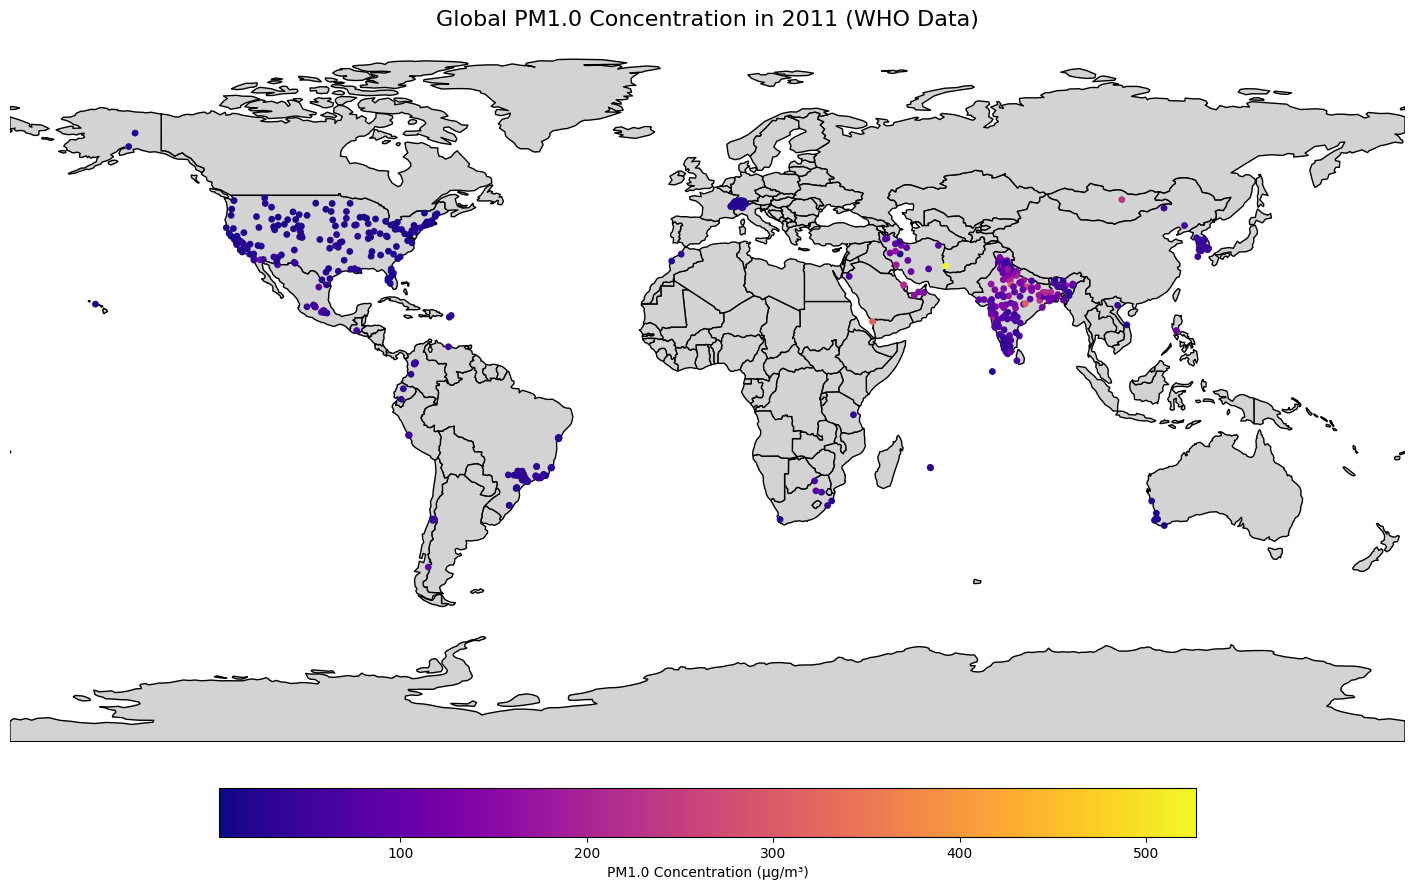

Saved frame for year 2011


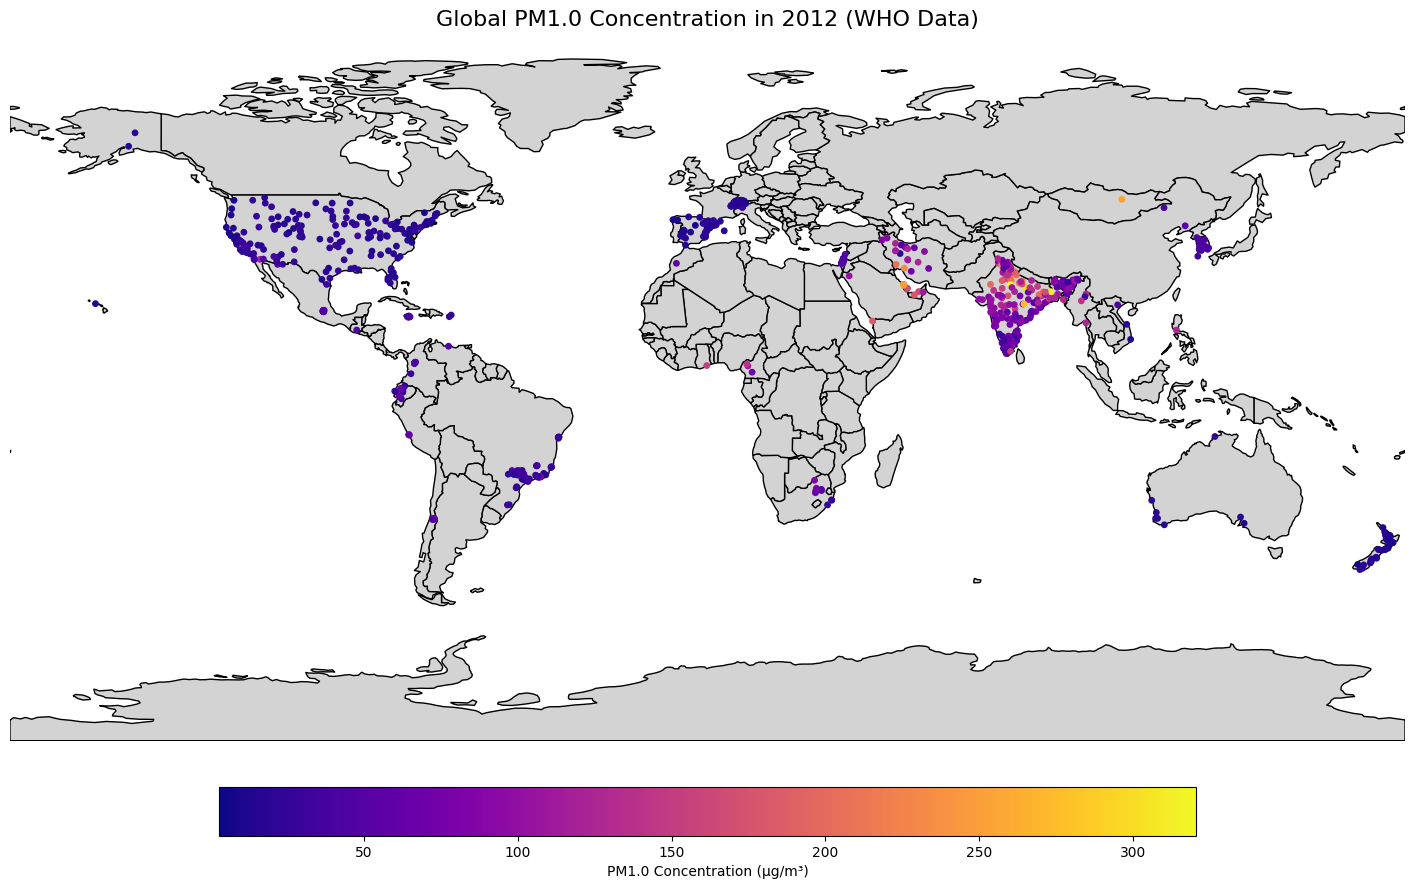

Saved frame for year 2012


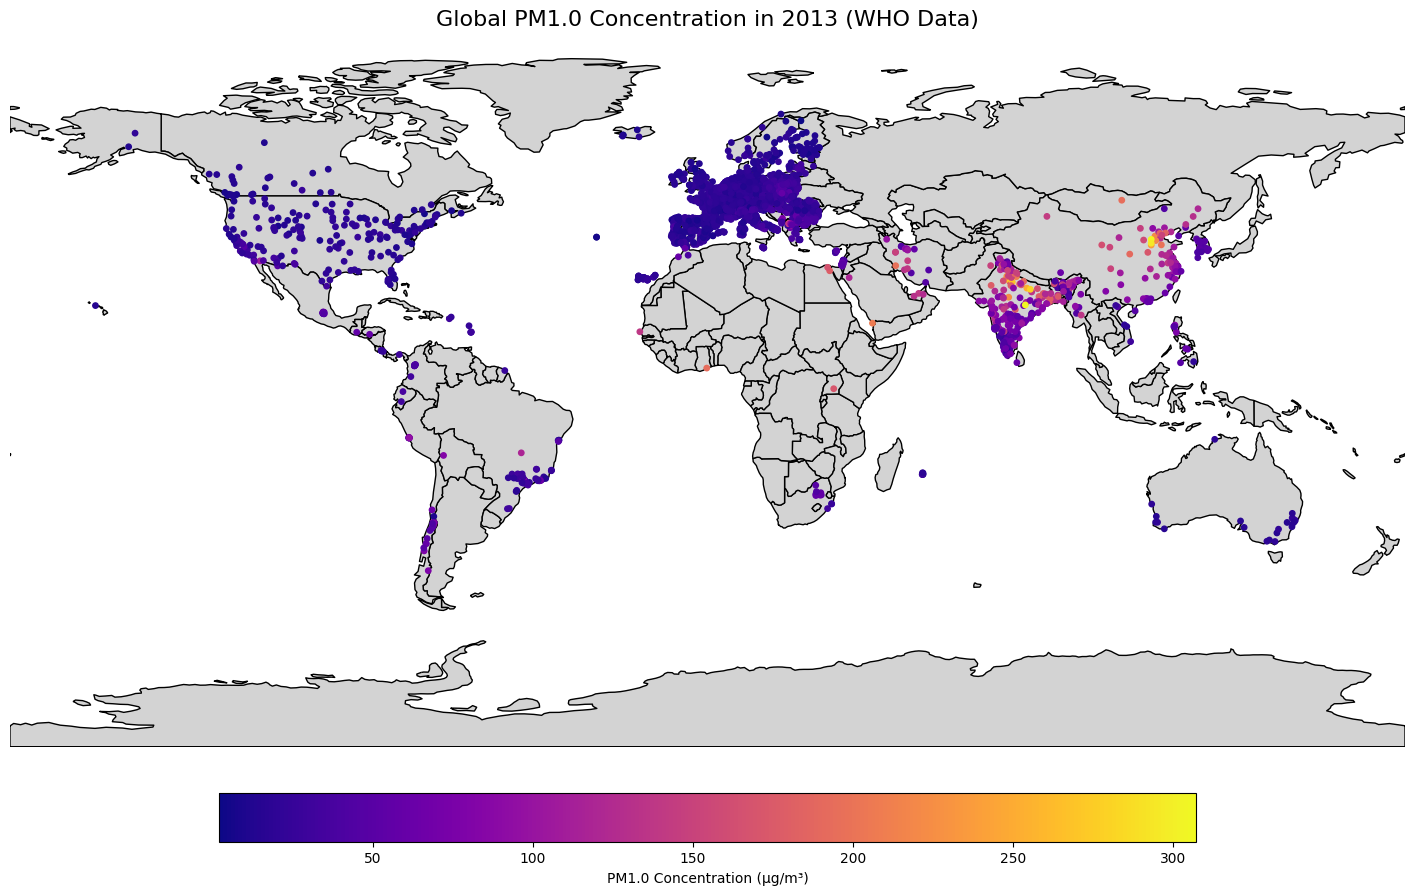

Saved frame for year 2013


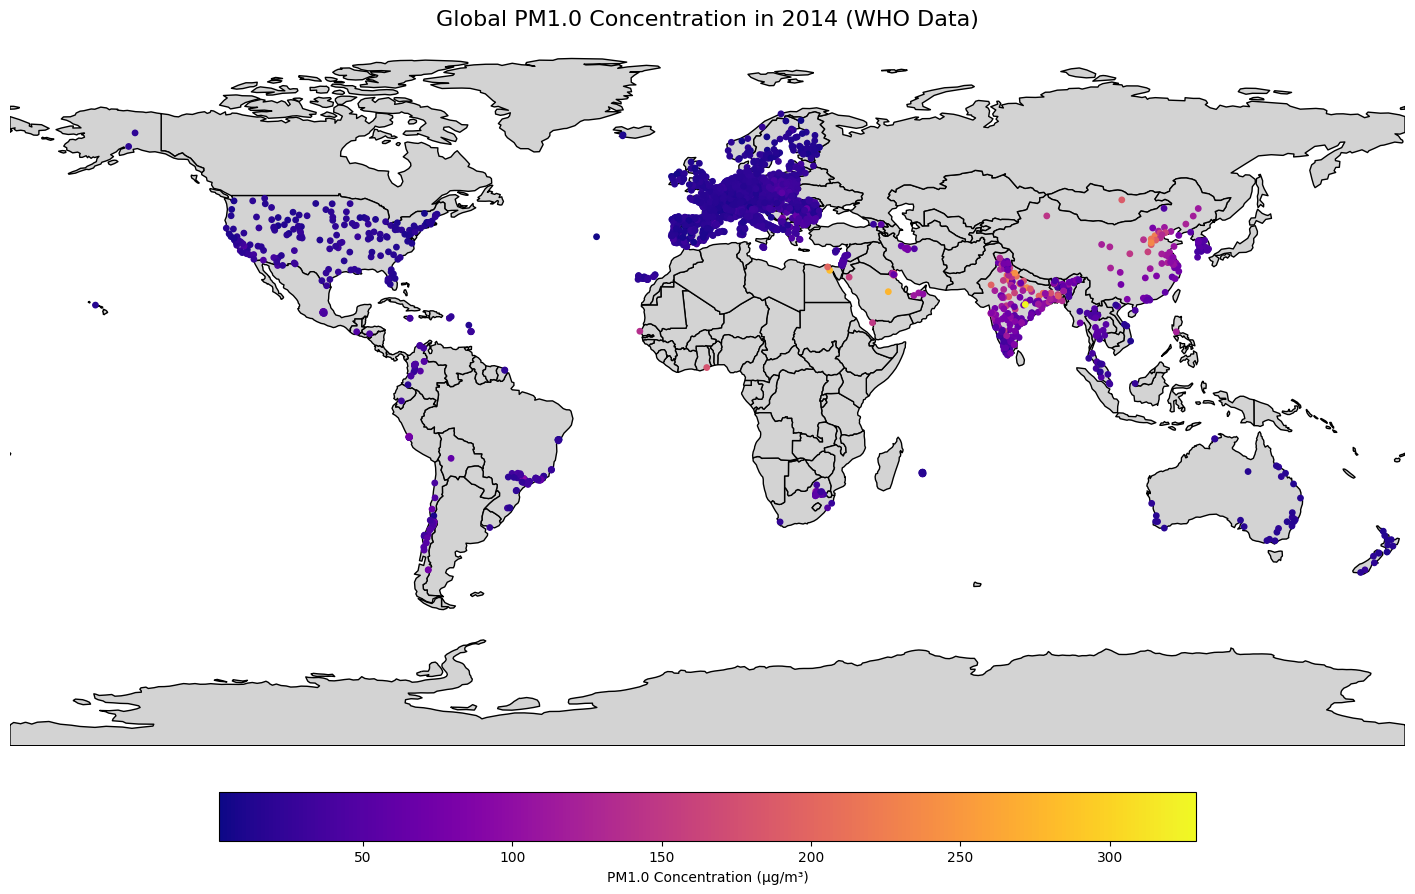

Saved frame for year 2014


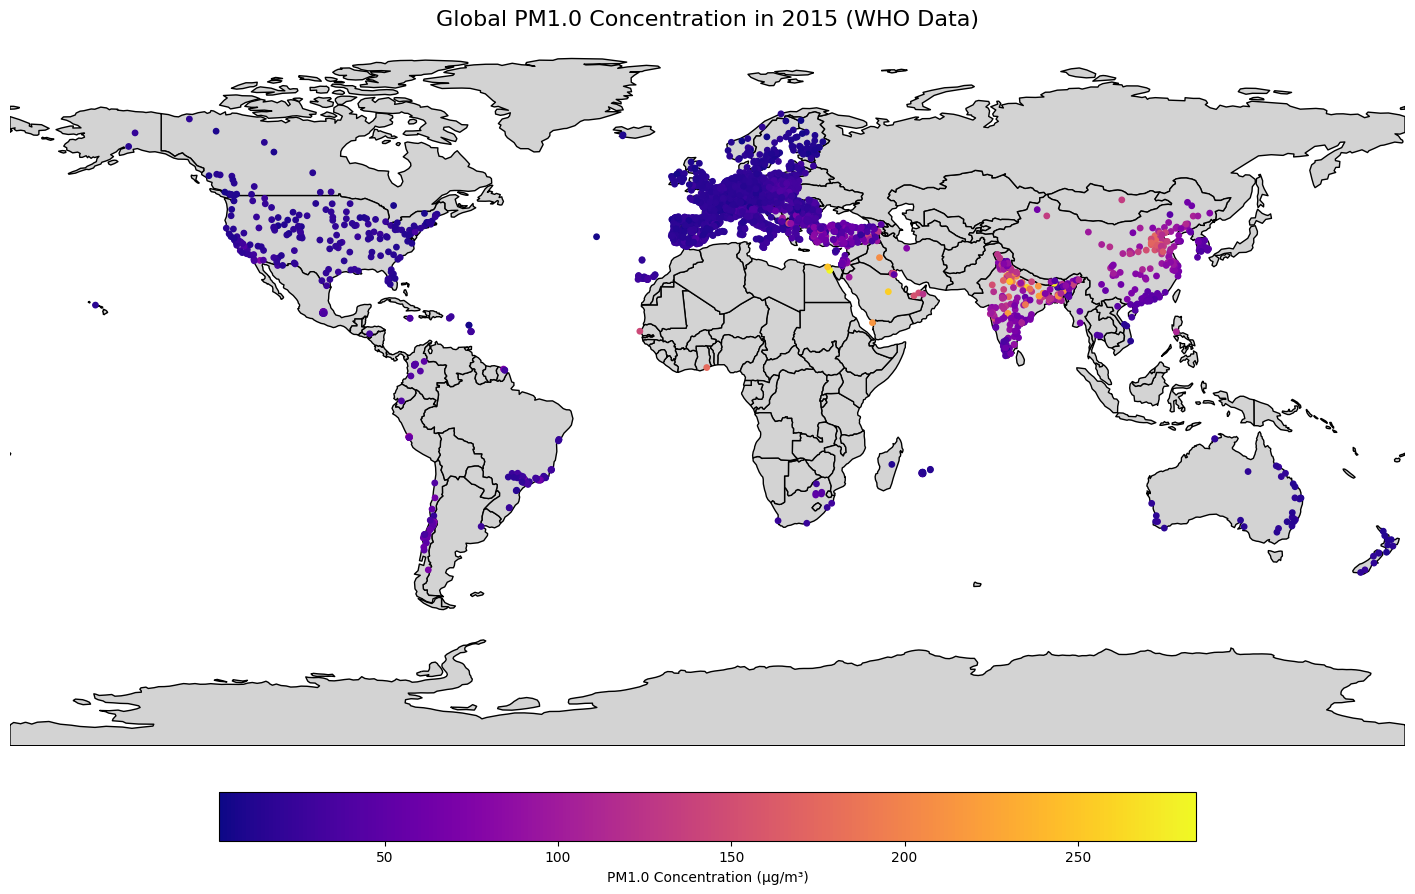

Saved frame for year 2015


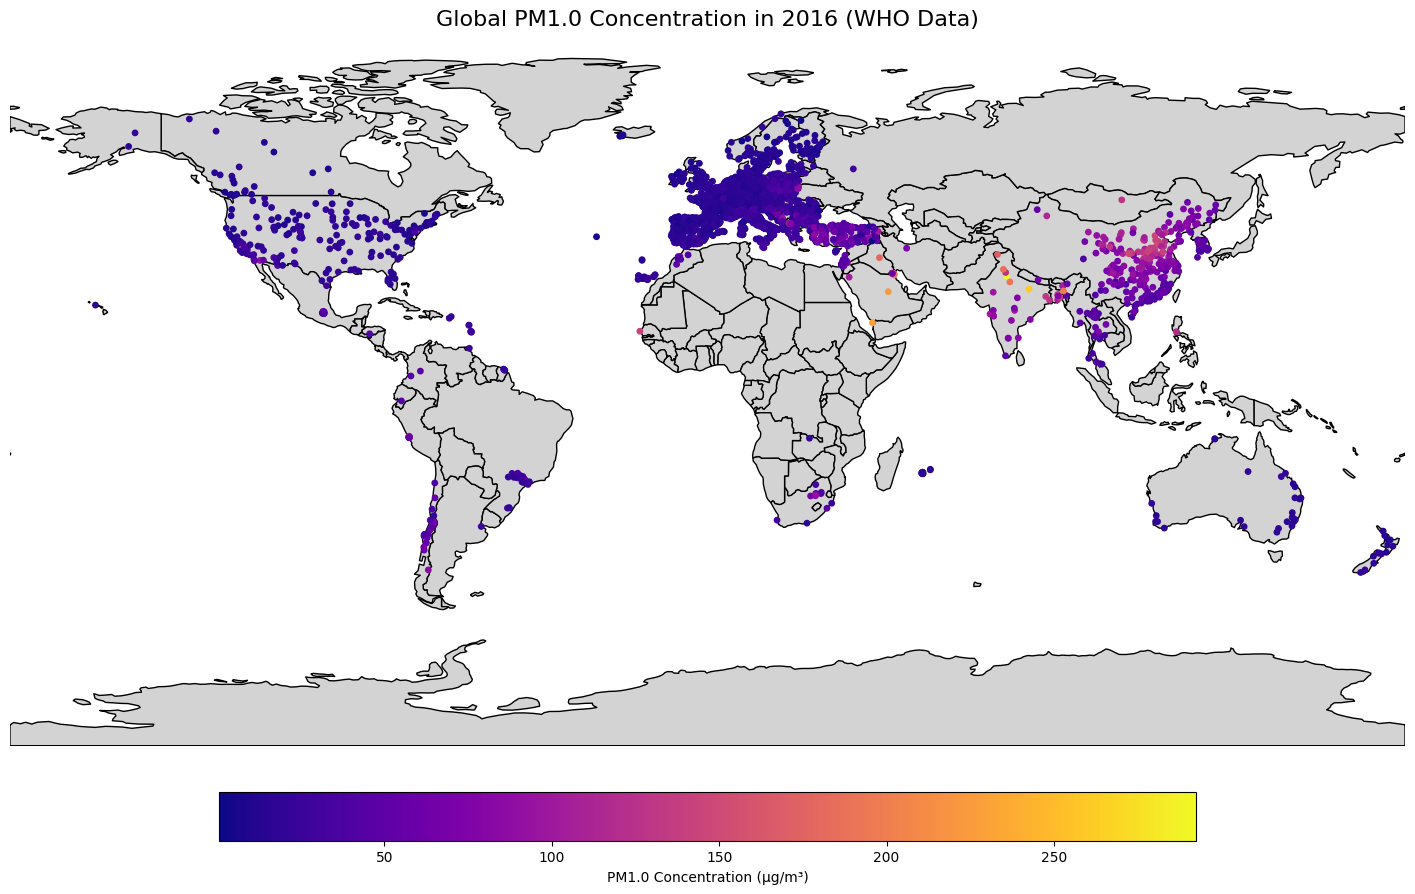

Saved frame for year 2016


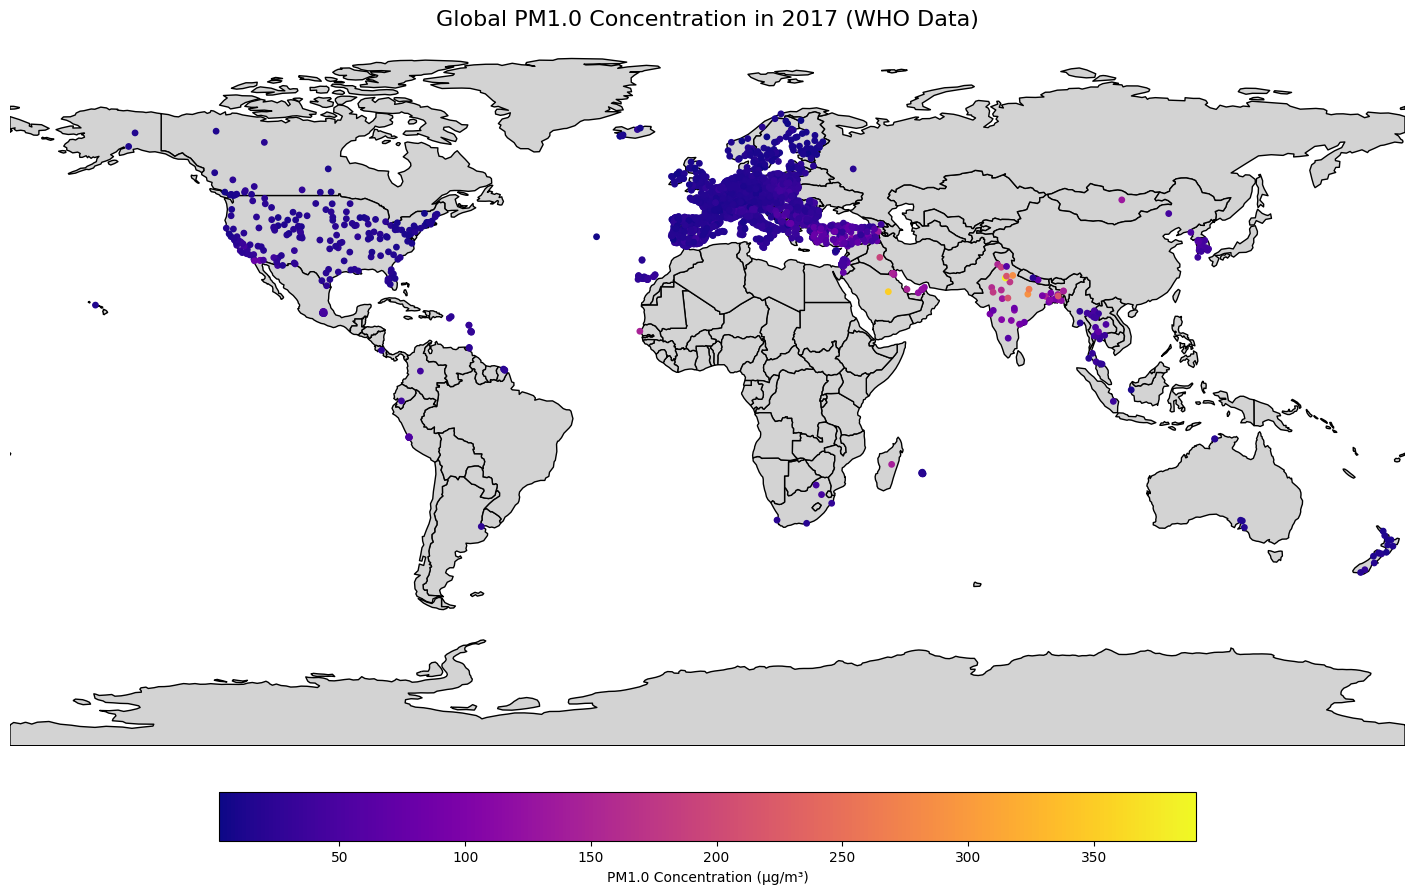

Saved frame for year 2017


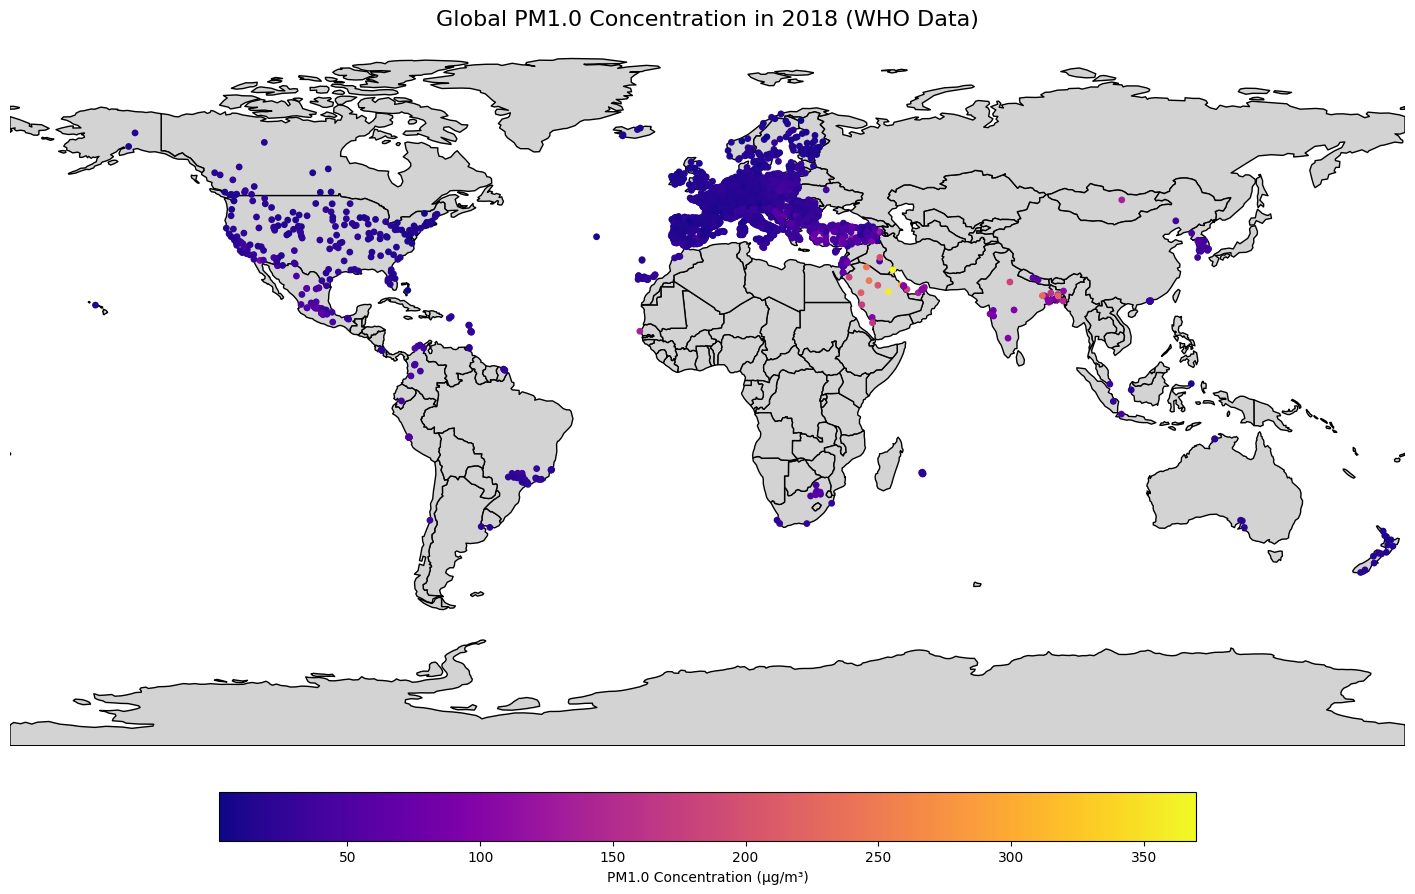

Saved frame for year 2018


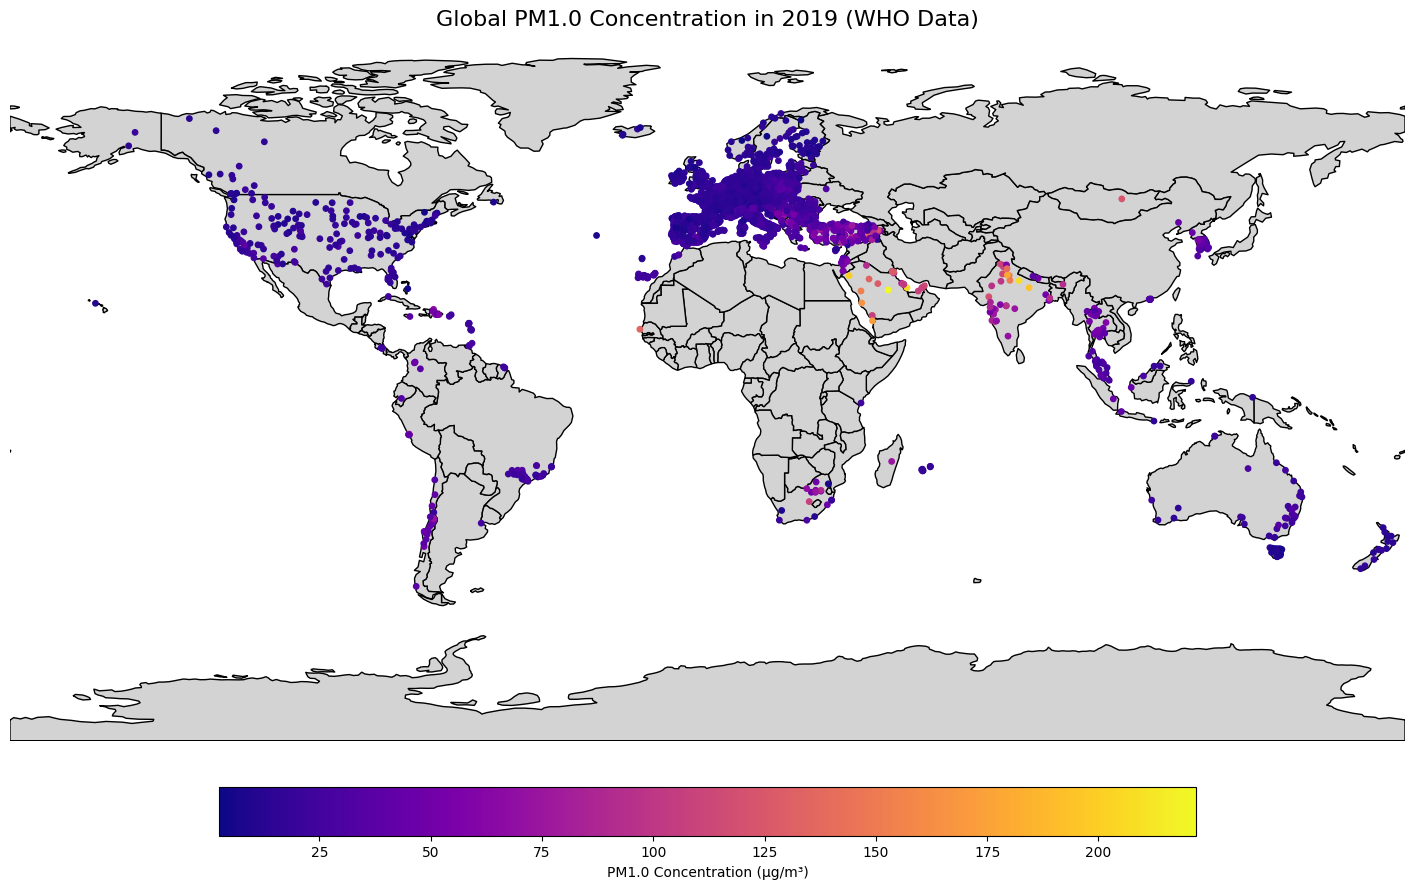

Saved frame for year 2019


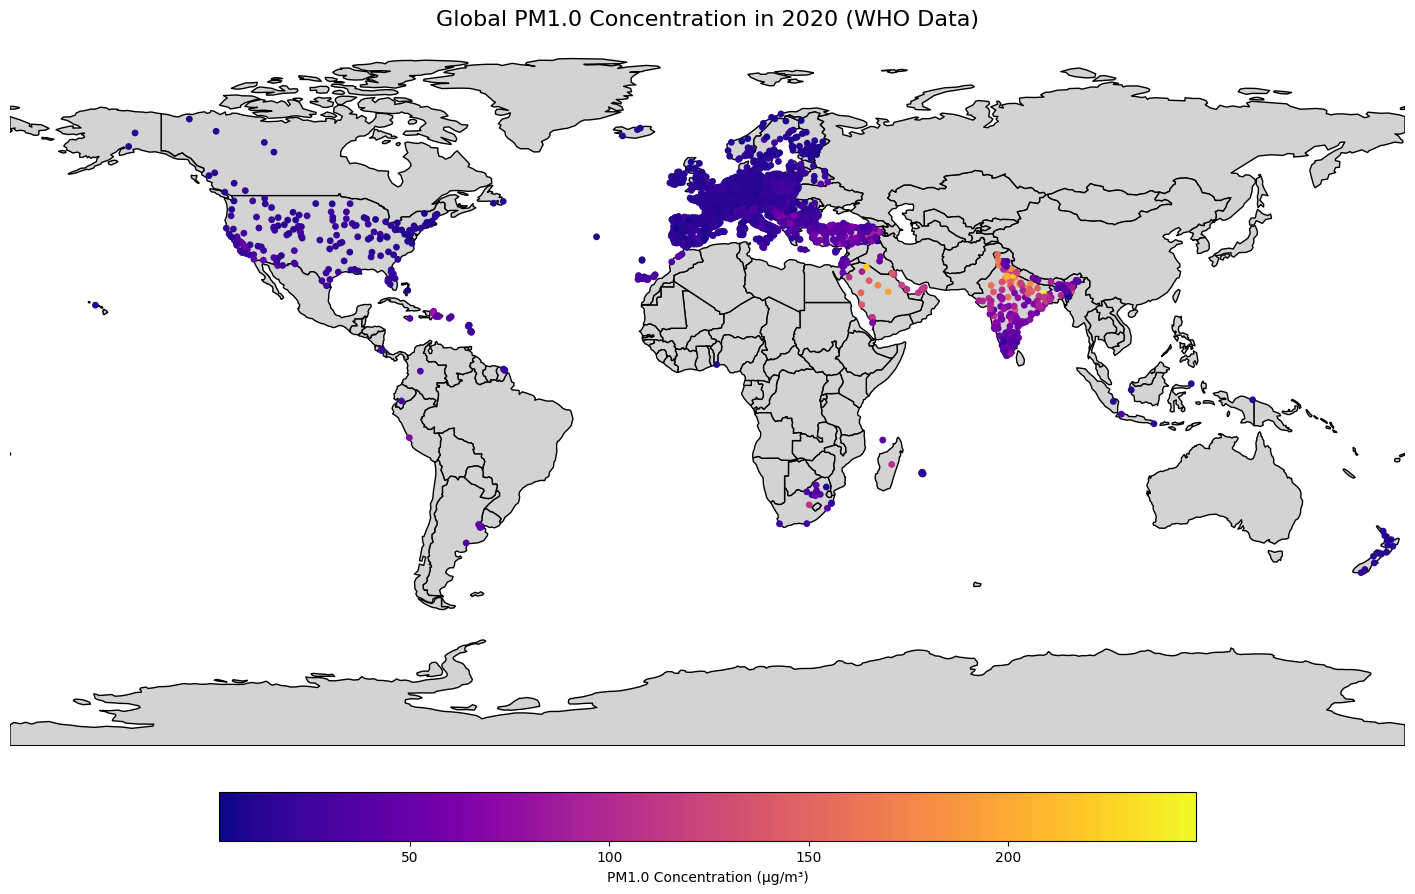

Saved frame for year 2020


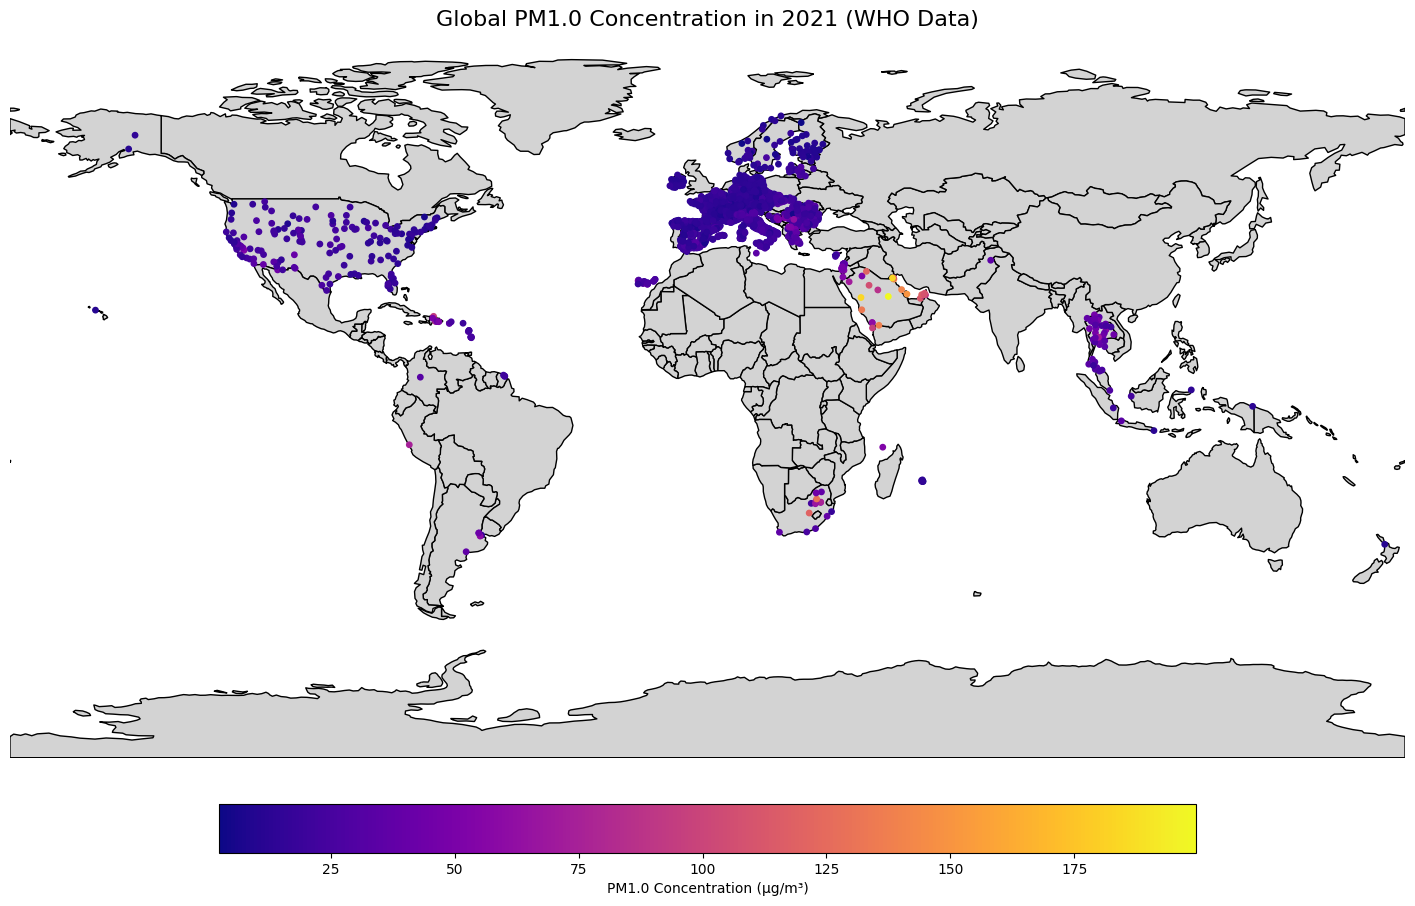

Saved frame for year 2021


In [36]:
# Get available years from your cleaned GeoDataFrame
available_years = sorted(gdf['year'].unique().tolist())
print(f"Years available in data: {available_years}")
image_paths = []

for year_to_plot in available_years:
        if year_to_plot != 2022:
              gdf_year = gdf[gdf['year'] == year_to_plot]

              fig, ax = plt.subplots(1, 1, figsize=(18, 12)) # Larger figure size for global map

              # Plot the world map for context
              world = gpd.read_file(world_map_shp_path)
              world.plot(ax=ax, color='lightgrey', edgecolor='black', zorder=0)

              # Plot the AQI data points on top
              # Using 'pm25_conc' for color, 'cmap' for colormap, 's' for marker size
              # 'legend=True' to show the color scale
              gdf_year.plot(column='pm10_concentration',
                            cmap='plasma', # Yellow-Orange-Red colormap (lower is better, higher is red)
                            markersize=15, # Adjust marker size as needed
                            legend=True,
                            legend_kwds={'label': "PM10 Concentration (µg/m³)",
                                        'orientation': "horizontal",
                                        'pad': 0.05, # Padding for the legend
                                        'shrink': 0.7}, # Shrink the legend size
                            ax=ax,
                            zorder=1) # Ensure points are above the world map

              ax.set_xlim([-180, 180]) # Longitude range
              ax.set_ylim([-90, 90])   # Latitude range
              ax.set_title(f'Global PM1.0 Concentration in {year_to_plot} (WHO Data)', fontsize=16)
              ax.set_xlabel('Longitude', fontsize=12)
              ax.set_ylabel('Latitude', fontsize=12)
              ax.set_axis_off() # Hide axes for cleaner map

              frame_path = os.path.join(temp_frames_dir, f'global_aqi_pm10_{year_to_plot}.png')
              plt.savefig(frame_path, dpi=150) # Use dpi for resolution
              image_paths.append(frame_path)
              plt.show()
              plt.close(fig) # IMPORTANT: Close the figure to free up memory
              print(f"Saved frame for year {year_to_plot}")

In [37]:
# Sort image paths to ensure correct animation order
image_paths.sort()
image_paths

['./temp_global_aqi_frames/global_aqi_pm10_2010.png',
 './temp_global_aqi_frames/global_aqi_pm10_2011.png',
 './temp_global_aqi_frames/global_aqi_pm10_2012.png',
 './temp_global_aqi_frames/global_aqi_pm10_2013.png',
 './temp_global_aqi_frames/global_aqi_pm10_2014.png',
 './temp_global_aqi_frames/global_aqi_pm10_2015.png',
 './temp_global_aqi_frames/global_aqi_pm10_2016.png',
 './temp_global_aqi_frames/global_aqi_pm10_2017.png',
 './temp_global_aqi_frames/global_aqi_pm10_2018.png',
 './temp_global_aqi_frames/global_aqi_pm10_2019.png',
 './temp_global_aqi_frames/global_aqi_pm10_2020.png',
 './temp_global_aqi_frames/global_aqi_pm10_2021.png']

In [38]:
if image_paths:
    # Read all images into a list
    images = [imageio.imread(file) for file in image_paths]

    # Create the GIF
    # 'fps' (frames per second) controls the speed of the animation.
    # 2 fps means each frame is shown for 0.5 seconds.
    imageio.mimsave(output_gif_path, images, fps=2)
    print(f"GIF saved successfully to: {output_gif_path}")
else:
    print("No image frames were generated to create the GIF. Check previous steps for errors.")


C:\Users\menak\AppData\Local\Temp\ipykernel_15592\245341930.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(file) for file in image_paths]


GIF saved successfully to: ./global_pm10_aqi_animation.gif


In [4]:
# Global Hotspot Analysis

In [7]:
import libpysal as ps # For spatial weights
import esda # For spatial statistics (e.g., Getis-Ord Gi*)
import numpy as np

In [8]:
# First, ensure 'geometry' is dropped before aggregation if it's not part of the groupby key
# Then reset index to make 'city', 'country_name', 'latitude', 'longitude' columns again
city_avg_df = gdf.drop(columns='geometry').groupby(['country_name', 'city', 'latitude', 'longitude'])[pollutant_column].mean().reset_index()

# Convert back to GeoDataFrame for spatial analysis
# Reuse the CRS as before
gdf_avg_pm10 = gpd.GeoDataFrame(
    city_avg_df,
    geometry=gpd.points_from_xy(city_avg_df.longitude, city_avg_df.latitude),
    crs="EPSG:4326"
)
print(f"Aggregated data for {len(gdf_avg_pm10)} unique cities.")
print("Aggregated GeoDataFrame Head:")
print(gdf_avg_pm10.head())


Aggregated data for 9874 unique cities.
Aggregated GeoDataFrame Head:
  country_name         city  latitude  longitude  pm10_concentration  \
0      Albania   Durres/ALB   41.3199    19.4492           26.499571   
1      Albania  Elbasan/ALB   41.1110    20.0817           48.500000   
2      Albania  Kastrat/ALB   42.3139    19.5234           22.308000   
3      Albania    Korce/ALB   40.6259    20.7802           40.093750   
4      Albania    Vlore/ALB   40.4031    19.4862           20.927200   

                  geometry  
0  POINT (19.4492 41.3199)  
1   POINT (20.0817 41.111)  
2  POINT (19.5234 42.3139)  
3  POINT (20.7802 40.6259)  
4  POINT (19.4862 40.4031)  


In [9]:
# 2. Define Spatial Relationships (Spatial Weights Matrix)
# We'll use a K-Nearest Neighbors (KNN) approach.
# A common choice for k is 8 for global data, ensuring every point has neighbors.
print("\nCreating K-Nearest Neighbors (KNN) spatial weights matrix (k=8)...")
# Ensure the CRS is projected for distance calculations if you want accurate distances,
# but for KNN based purely on coordinate proximity, a geographic CRS like 4326 is fine.
# For accurate distance-based weights, one might project first.
# Here, we stick to 4326 for simplicity and consistent mapping.
k = 8
wq = ps.weights.KNN.from_dataframe(gdf_avg_pm10, k=k)
wq.ids = gdf_avg_pm10.index # Assign original index as IDs for weights object
wq.transform = 'r' # Row-standardization (sum of weights for each row is 1)
print(f"Spatial weights matrix created with {k} nearest neighbors.")



Creating K-Nearest Neighbors (KNN) spatial weights matrix (k=8)...
Spatial weights matrix created with 8 nearest neighbors.


D:\MSc SJP\GIS\Assignment\InvisibleBreath\gis\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 42 disconnected components.
  warnings.warn(message)


In [12]:
# 3. Perform Hotspot Analysis (Getis-Ord Gi*)
print(f"\nPerforming Getis-Ord Gi* hotspot analysis on average '{pollutant_column}'...")
# The 'pollutant_column' variable from previous cells holds 'pm10_conc' or 'pm10_concentration'
gi_star = esda.G_Local(gdf_avg_pm10[pollutant_column], wq)
gi_star = esda.G_Local(gdf_avg_pm10[pollutant_column], wq)

print("Attributes available in the 'gi_star' object:")
print(dir(gi_star))

# You can also try to print the type to ensure it's what we expect
print(f"\nType of gi_star object: {type(gi_star)}")


Performing Getis-Ord Gi* hotspot analysis on average 'pm10_concentration'...
Attributes available in the 'gi_star' object:
['EG_sim', 'EGs', 'Gs', 'VG_sim', 'VGs', 'Zs', '_G_Local__crand', '_G_Local__getCardinalities', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_statistic', 'by_col', 'calc', 'n', 'p_norm', 'p_sim', 'p_z_sim', 'permutations', 'rGs', 'seG_sim', 'sim', 'star', 'w', 'w_transform', 'y', 'y_sum', 'z_sim']

Type of gi_star object: <class 'esda.getisord.G_Local'>


In [13]:

# Add Gi* results to the GeoDataFrame
gdf_avg_pm10['g_statistic'] = gi_star.Gs # <--- This is the correct attribute based on dir(gi_star)
# --- END CORRECTED LINE ---
gdf_avg_pm10['p_value'] = gi_star.p_sim # p-value from permutation
gdf_avg_pm10['z_score'] = gi_star.z_sim # z-score from permutation

# Classify hotspots and coldspots based on statistical significance
# A common significance level is 0.05.
# Hotspot: High G-statistic and statistically significant (high z-score, low p-value)
# Coldspot: Low G-statistic and statistically significant (low z-score, low p-value)

# Create a classification column for visualization
# Categories:
# 1 = Significant Hotspot (High-High Cluster)
# 2 = Significant Coldspot (Low-Low Cluster)
# 0 = Not Significant / Other
print("Classifying cities into Hotspots, Coldspots, and Not Significant...")
alpha = 0.05 # Significance level

gdf_avg_pm10['hotspot_type'] = 'Not Significant'
# Significant Hotspot (High value surrounded by high values)
gdf_avg_pm10.loc[(gi_star.p_sim < alpha) & (gi_star.z_sim > 0), 'hotspot_type'] = 'Hotspot'
# Significant Coldspot (Low value surrounded by low values)
gdf_avg_pm10.loc[(gi_star.p_sim < alpha) & (gi_star.z_sim < 0), 'hotspot_type'] = 'Coldspot'

print("\nHotspot analysis complete. Results added to GeoDataFrame.")
print("Hotspot/Coldspot type counts:")
print(gdf_avg_pm10['hotspot_type'].value_counts())


Classifying cities into Hotspots, Coldspots, and Not Significant...

Hotspot analysis complete. Results added to GeoDataFrame.
Hotspot/Coldspot type counts:
hotspot_type
Not Significant    5254
Coldspot           3257
Hotspot            1363
Name: count, dtype: int64



Generating Hotspot/Coldspot map...


C:\Users\menak\AppData\Local\Temp\ipykernel_24144\2323120624.py:16: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  gdf_avg_pm10.plot(column='hotspot_type',


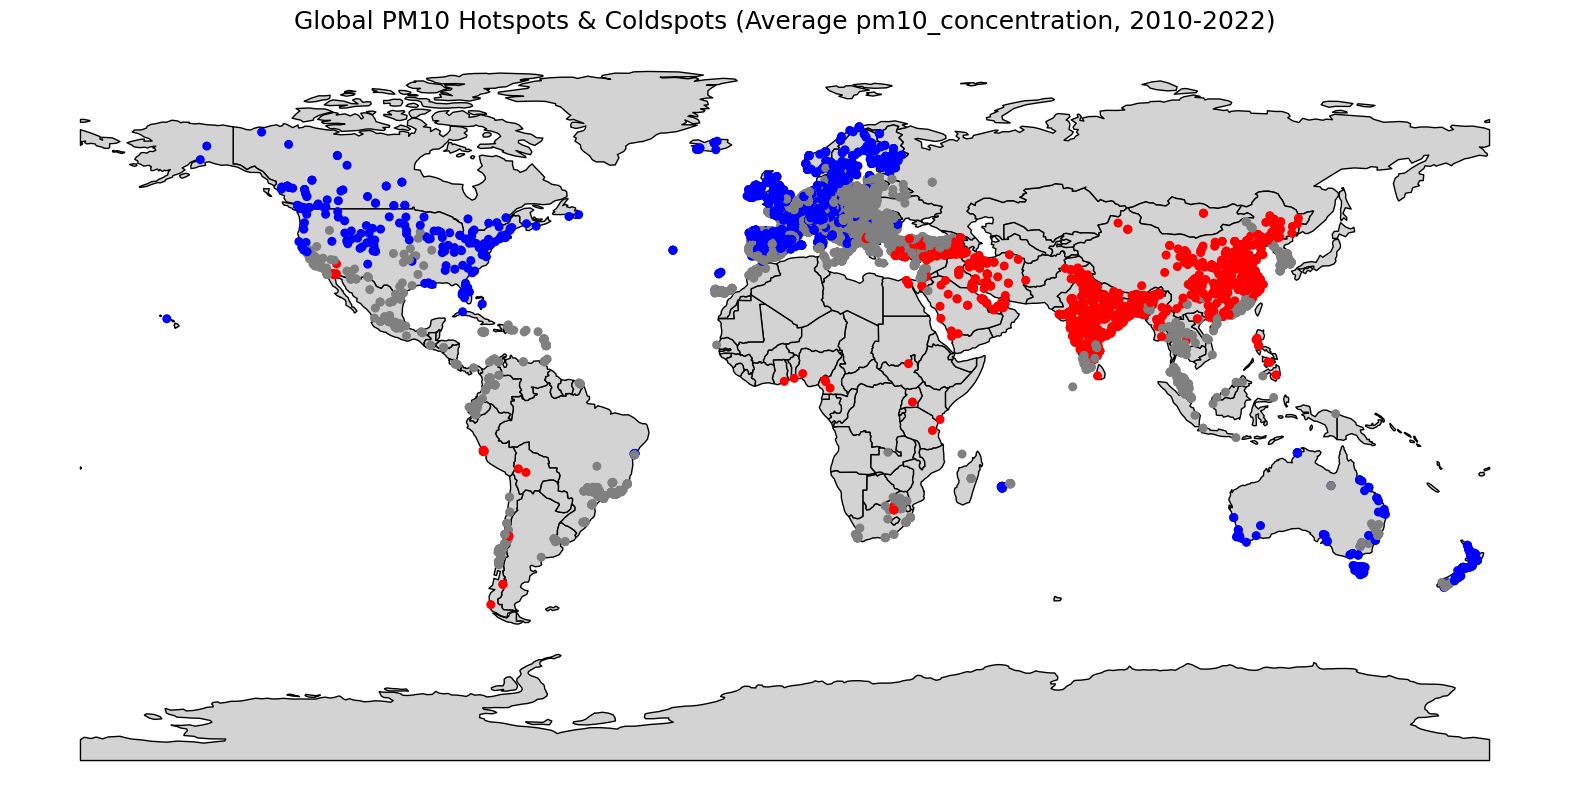


--- Hotspot Analysis Complete ---


In [15]:
print("\nGenerating Hotspot/Coldspot map...")

fig, ax = plt.subplots(1, 1, figsize=(20, 15))

# Plot the world map for context
world.plot(ax=ax, color='lightgrey', edgecolor='black', zorder=0)

# Define custom colors for hotspot types
hotspot_colors = {
    'Hotspot': 'red',
    'Coldspot': 'blue',
    'Not Significant': 'grey' # Or a very light color to show these points but not highlight them
}

# Plot the cities, colored by hotspot_type
gdf_avg_pm10.plot(column='hotspot_type',
                   cmap=None, # We'll use custom colors defined below
                   color=[hotspot_colors[h] for h in gdf_avg_pm10['hotspot_type']],
                   markersize=30, # Slightly larger markers for better visibility
                   legend=True,
                   legend_kwds={'loc': 'lower left', 'title': 'PM10 Hotspot Type'},
                   ax=ax,
                   zorder=1)

ax.set_title(f'Global PM10 Hotspots & Coldspots (Average {pollutant_column}, 2010-2022)', fontsize=18)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_axis_off() # Hide axes for cleaner map

# Optionally, save this map
# hotspot_map_path = './global_pm10_hotspot_map.png'
# plt.savefig(hotspot_map_path, bbox_inches='tight', dpi=200)
# print(f"Hotspot map saved to: {hotspot_map_path}")

plt.show()

print("\n--- Hotspot Analysis Complete ---")

In [16]:
# Cell Y: Cross-Regional Comparative Trend Analysis

print("\n--- Starting Cross-Regional Comparative Trend Analysis ---")

# 1. Assign Continents to Data
# The 'world' GeoDataFrame (Natural Earth countries) usually has a 'CONTINENT' column.
# We'll merge our AQI data (gdf) with the 'world' data to get continent information for each city.

# First, ensure country names can be matched.
# 'gdf' has 'country_name', 'world' typically has 'NAME' or 'NAME_LONG'.
# Let's check columns for 'world' to confirm the country name column
# print("World GeoDataFrame columns:", world.columns.tolist()) # Uncomment to check
# For Natural Earth 1:110m, 'NAME' is common. Adjust 'on=' if your 'world' GeoDataFrame uses a different column.

# Select relevant columns from 'world' (country name and continent)
world_continents = world[['NAME', 'CONTINENT', 'geometry']].copy()
world_continents.rename(columns={'NAME': 'country_name'}, inplace=True) # Rename to match gdf

# Perform a left merge to add 'CONTINENT' to 'gdf'
# We're merging on 'country_name'. Some countries might not match exactly, resulting in NaNs for CONTINENT.
gdf_with_continents = pd.merge(
    gdf,
    world_continents[['country_name', 'CONTINENT']],
    on='country_name',
    how='left'
)




--- Starting Cross-Regional Comparative Trend Analysis ---


In [17]:
# Check for unassigned continents
print(f"Number of data points with unassigned continents (NaN): {gdf_with_continents['CONTINENT'].isna().sum()}")
# You might want to inspect these:
# print(gdf_with_continents[gdf_with_continents['CONTINENT'].isna()]['country_name'].unique())
# For simplicity, we'll drop them for this analysis, or assign to 'Unknown'
gdf_with_continents.dropna(subset=['CONTINENT'], inplace=True)
print(f"Number of data points after dropping unassigned continents: {len(gdf_with_continents)}")




Number of data points with unassigned continents (NaN): 2321
Number of data points after dropping unassigned continents: 26351


In [18]:
# 2. Aggregate PM10 Concentration by Continent and Year
print("\nAggregating PM10 concentration by Continent and Year...")
# Using the pollutant_column (e.g., 'pm10_conc' or 'pm10_concentration')
continent_yearly_trends = gdf_with_continents.groupby(['year', 'CONTINENT'])[pollutant_column].mean().reset_index()

print("Continent-Yearly Trends Head:")
print(continent_yearly_trends.head())





Aggregating PM10 concentration by Continent and Year...
Continent-Yearly Trends Head:
   year      CONTINENT  pm10_concentration
0  2010         Africa           66.463455
1  2010           Asia          179.332368
2  2010         Europe           25.915942
3  2010  North America           22.739640
4  2010        Oceania           19.053400



Generating time-series trend plots for each continent...


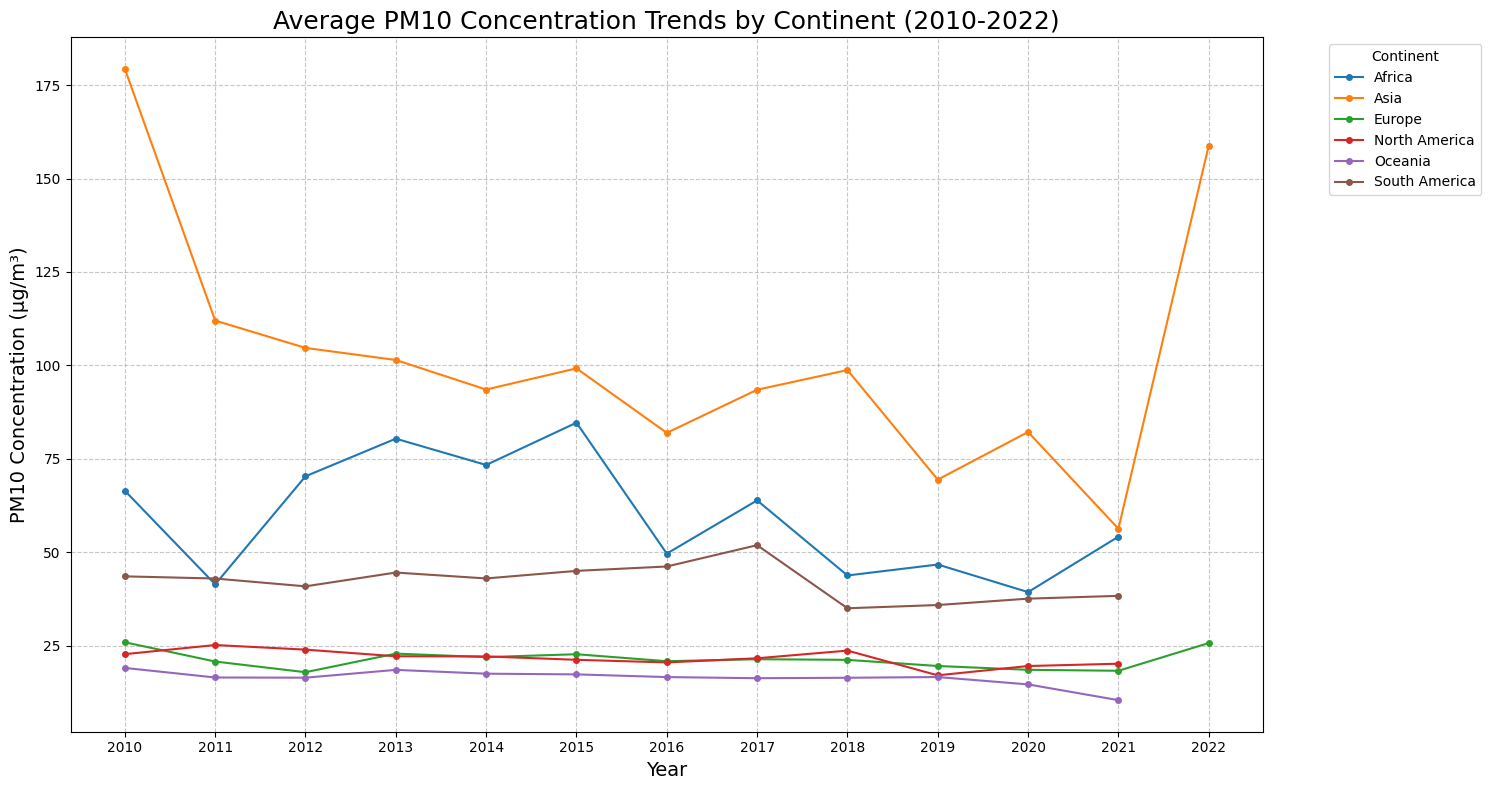


--- Cross-Regional Trend Analysis Complete ---


In [19]:
# 3. Visualize Trends
print("\nGenerating time-series trend plots for each continent...")

# Ensure matplotlib is set up for plotting
plt.figure(figsize=(15, 8))

# Loop through each unique continent and plot its trend
for continent in sorted(continent_yearly_trends['CONTINENT'].unique()):
    continent_data = continent_yearly_trends[continent_yearly_trends['CONTINENT'] == continent]
    plt.plot(continent_data['year'], continent_data[pollutant_column], label=continent, marker='o', markersize=4)

plt.title(f'Average PM10 Concentration Trends by Continent (2010-2022)', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel(legend_label, fontsize=14) # Using the legend_label from previous cells
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Continent', bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside
plt.xticks(continent_yearly_trends['year'].unique()) # Ensure all years are marked on x-axis
plt.tight_layout() # Adjust layout to prevent labels overlapping
# plt.savefig('./global_pm10_continent_trends.png', dpi=200, bbox_inches='tight') # Uncomment to save
plt.show()

print("\n--- Cross-Regional Trend Analysis Complete ---")

In [20]:
# Cell Z: Quantifying Temporal Trends with Statistical Analysis

import scipy.stats as stats
import pandas as pd # Ensure pandas is imported, though it should be already

print("\n--- Quantifying Temporal Trends for Each Continent ---")

# Reuse the 'continent_yearly_trends' DataFrame from the previous step
# (Cell Y, where you aggregated PM10 by year and continent)

if 'continent_yearly_trends' not in locals():
    print("Error: 'continent_yearly_trends' DataFrame not found. Please run the previous cells first.")
else:
    trend_results = []

    # Loop through each unique continent
    for continent in sorted(continent_yearly_trends['CONTINENT'].unique()):
        continent_data = continent_yearly_trends[continent_yearly_trends['CONTINENT'] == continent]

        # Ensure there's enough data points (at least 2 years for a regression)
        if len(continent_data) > 1:
            years = continent_data['year']
            pm10_values = continent_data[pollutant_column]

            # Perform linear regression: y = mx + b
            # slope: rate of change (µg/m³ per year)
            # intercept: PM10 at year 0 (not directly interpretable here, but part of the model)
            # r_value: correlation coefficient (sqrt(R-squared))
            # p_value: statistical significance of the slope
            # std_err: standard error of the slope
            slope, intercept, r_value, p_value, std_err = stats.linregress(years, pm10_values)

            # R-squared value
            r_squared = r_value**2

            trend_results.append({
                'Continent': continent,
                'Slope (µg/m³/year)': slope,
                'P-value': p_value,
                'R-squared': r_squared,
                'Trend Significance': 'Significant (p < 0.05)' if p_value < 0.05 else 'Not Significant'
            })
        else:
            trend_results.append({
                'Continent': continent,
                'Slope (µg/m³/year)': None,
                'P-value': None,
                'R-squared': None,
                'Trend Significance': 'Not enough data'
            })

    # Convert results to a DataFrame for easy viewing
    trends_df = pd.DataFrame(trend_results)

    print("\n--- Statistical Trend Analysis Results ---")
    print(trends_df.round(4)) # Round to 4 decimal places for cleaner output

    print("\nInterpretation:")
    print("- 'Slope (µg/m³/year)' indicates the average change in PM10 per year.")
    print("  - Positive slope: increasing trend (worsening air quality)")
    print("  - Negative slope: decreasing trend (improving air quality)")
    print("- 'P-value' indicates statistical significance.")
    print("  - A P-value < 0.05 usually means the trend is statistically significant (unlikely due to random chance).")
    print("- 'R-squared' indicates how much of the variation in PM10 is explained by the year.")
    print("  - A higher R-squared (closer to 1) means the linear model fits the data better.")

print("\n--- Quantifying Trends Complete ---")


--- Quantifying Temporal Trends for Each Continent ---

--- Statistical Trend Analysis Results ---
       Continent  Slope (µg/m³/year)  P-value  R-squared  \
0         Africa             -1.9773   0.1385     0.2058   
1           Asia             -3.2032   0.2093     0.1392   
2         Europe             -0.1306   0.5114     0.0402   
3  North America             -0.4247   0.0111     0.4917   
4        Oceania             -0.4379   0.0079     0.5221   
5  South America             -0.5623   0.1737     0.1767   

       Trend Significance  
0         Not Significant  
1         Not Significant  
2         Not Significant  
3  Significant (p < 0.05)  
4  Significant (p < 0.05)  
5         Not Significant  

Interpretation:
- 'Slope (µg/m³/year)' indicates the average change in PM10 per year.
  - Positive slope: increasing trend (worsening air quality)
  - Negative slope: decreasing trend (improving air quality)
- 'P-value' indicates statistical significance.
  - A P-value < 0.05 usual